In [1]:
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from IPython.display import display
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects


mHTT data shape: (10, 2048, 2048)
CCT1 data shape: (10, 2048, 2048)
Saved 10 Z-slices for mHTT to 'mhtt_z_slices'
Saved 10 Z-slices for CCT1 to 'cct1_z_slices'


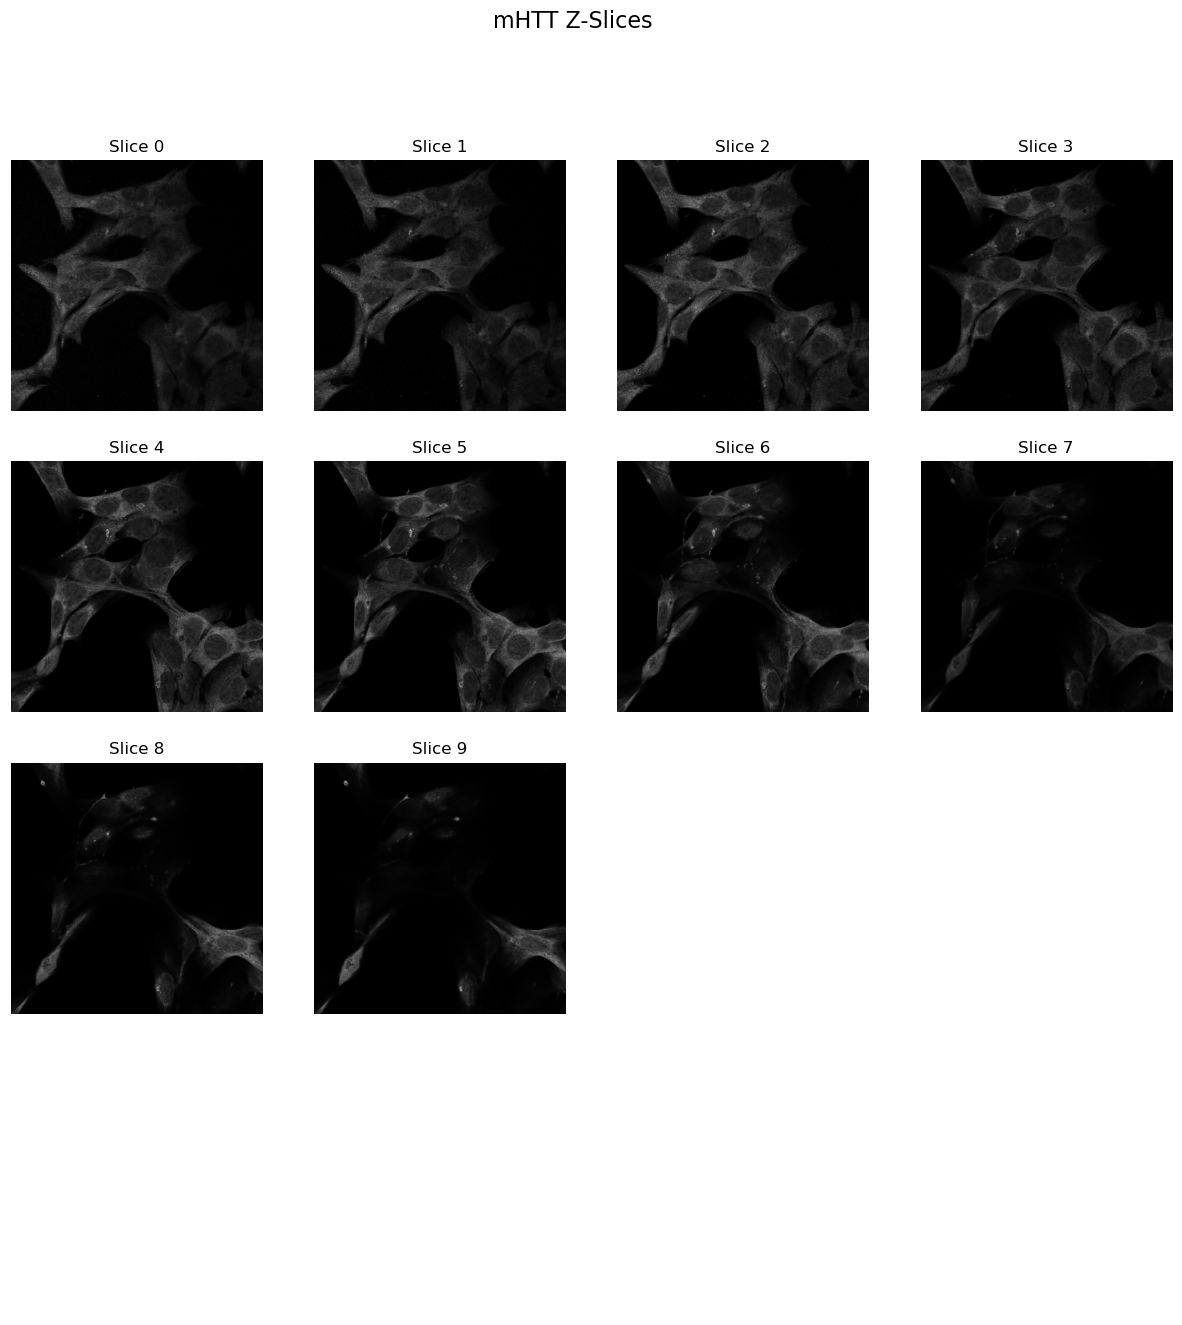

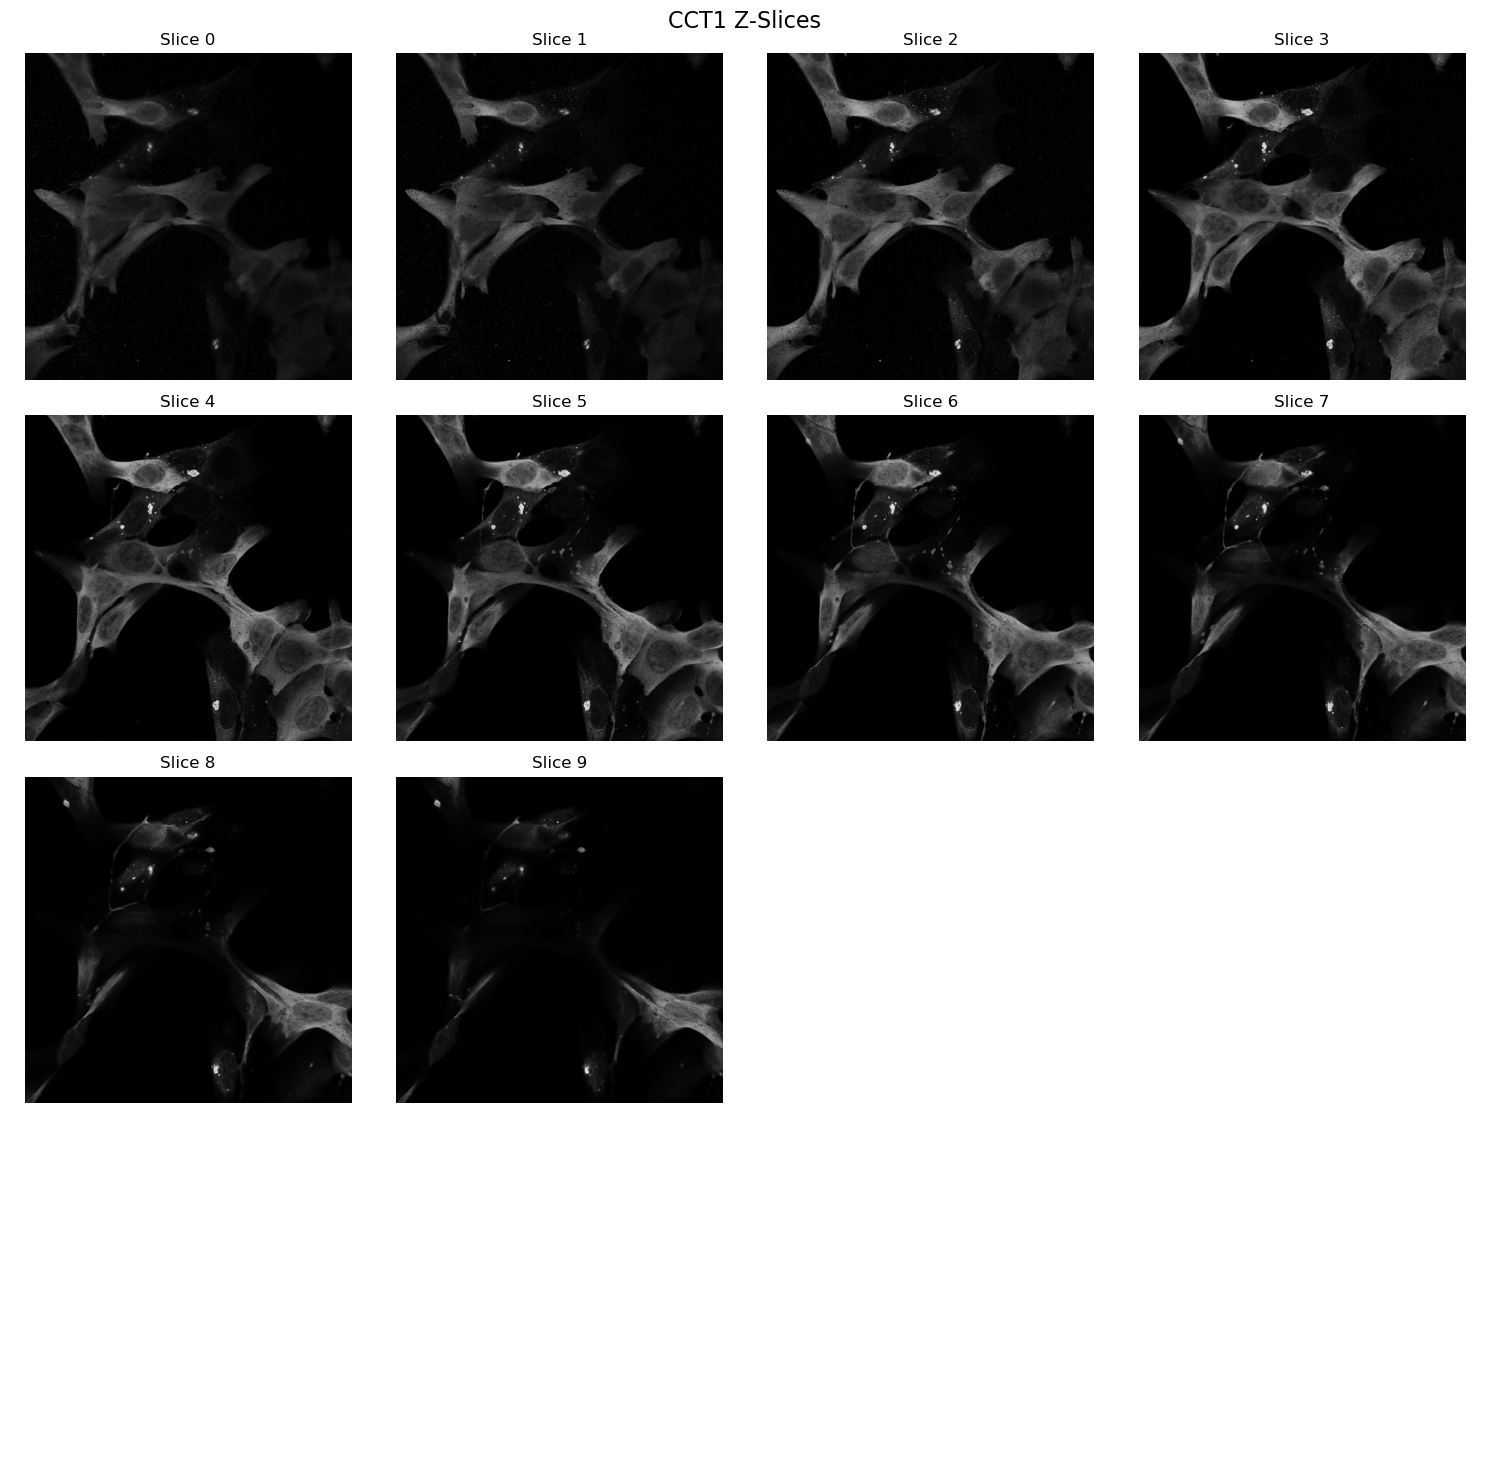

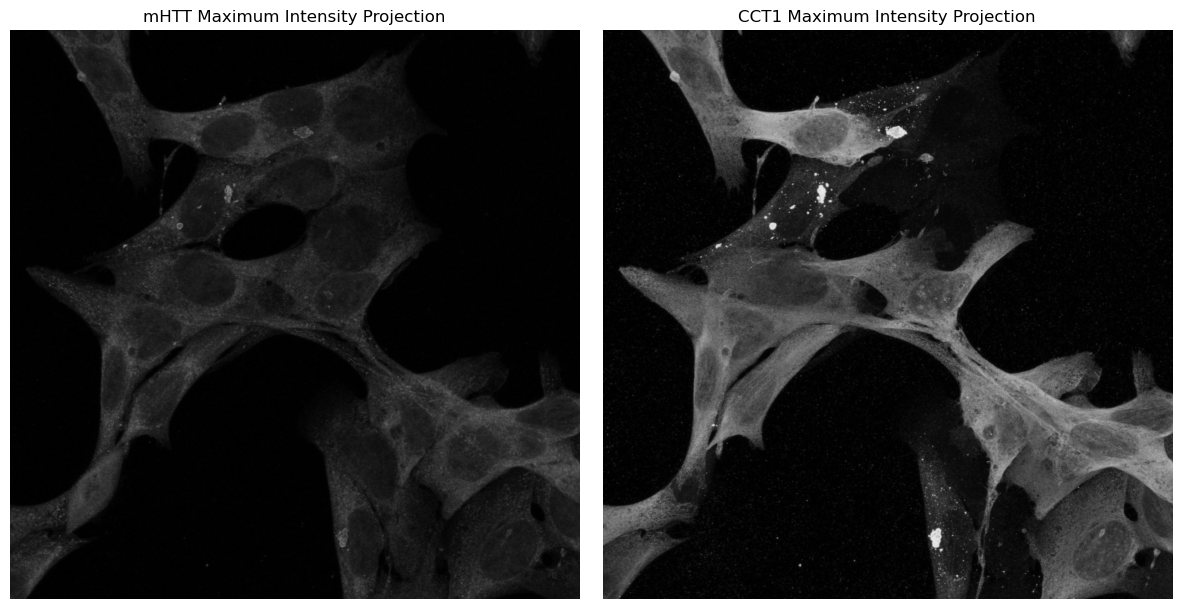

In [2]:


# File paths
mhtt_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=0.tif'
cct1_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=1.tif'

# Load the TIFF files
mhtt_data = tifffile.imread(mhtt_path)  # Shape: (Z, Y, X)
cct1_data = tifffile.imread(cct1_path)  # Shape: (Z, Y, X)

# Verify the shapes
print(f"mHTT data shape: {mhtt_data.shape}")
print(f"CCT1 data shape: {cct1_data.shape}")

# Create output directories for Z-slices
mhtt_output_dir = "mhtt_z_slices"
cct1_output_dir = "cct1_z_slices"
os.makedirs(mhtt_output_dir, exist_ok=True)
os.makedirs(cct1_output_dir, exist_ok=True)

# Save each Z-slice as a separate TIFF file
for z in range(mhtt_data.shape[0]):
    mhtt_slice_path = os.path.join(mhtt_output_dir, f"mhtt_slice_{z}.tiff")
    cct1_slice_path = os.path.join(cct1_output_dir, f"cct1_slice_{z}.tiff")
    
    # Save mHTT Z-slice
    tifffile.imwrite(mhtt_slice_path, mhtt_data[z])
    
    # Save CCT1 Z-slice
    tifffile.imwrite(cct1_slice_path, cct1_data[z])

print(f"Saved {mhtt_data.shape[0]} Z-slices for mHTT to '{mhtt_output_dir}'")
print(f"Saved {cct1_data.shape[0]} Z-slices for CCT1 to '{cct1_output_dir}'")

# Display all Z-slices in a grid
num_slices = mhtt_data.shape[0]
grid_size = int(np.ceil(np.sqrt(num_slices)))

# Create a figure to display all mHTT Z-slices
fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig1.suptitle('mHTT Z-Slices', fontsize=16)

# Create a figure to display all CCT1 Z-slices
fig2, axes2 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig2.suptitle('CCT1 Z-Slices', fontsize=16)

# Normalize the intensity for better visualization
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Plot each Z-slice
for z in range(num_slices):
    row, col = z // grid_size, z % grid_size
    
    # mHTT slice
    ax1 = axes1[row, col]
    ax1.imshow(normalize(mhtt_data[z]), cmap='gray')
    ax1.set_title(f"Slice {z}")
    ax1.axis('off')
    
    # CCT1 slice
    ax2 = axes2[row, col]
    ax2.imshow(normalize(cct1_data[z]), cmap='gray')
    ax2.set_title(f"Slice {z}")
    ax2.axis('off')

# Turn off remaining empty subplots
for z in range(num_slices, grid_size**2):
    row, col = z // grid_size, z % grid_size
    axes1[row, col].axis('off')
    axes2[row, col].axis('off')

plt.tight_layout()
plt.show()

# Create maximum intensity projections (MIP)
mhtt_mip = np.max(mhtt_data, axis=0)
cct1_mip = np.max(cct1_data, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(normalize(mhtt_mip), cmap='gray')
plt.title("mHTT Maximum Intensity Projection")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalize(cct1_mip), cmap='gray')
plt.title("CCT1 Maximum Intensity Projection")
plt.axis('off')

plt.tight_layout()
plt.show()


when combining the slices for visualization, I use a maximum intensity projection (MIP). It works like this:
	•	It goes through each pixel column in the Z-stack (i.e., the same (X, Y) position across all Z-layers).
	•	For each (X, Y) pixel location, I select the maximum intensity value from all Z-slices.
	•	The result is a single 2D image where each pixel shows the brightest value observed in that column of Z-slices.

This just for visualization, the actual analysis is performed across different z-slices

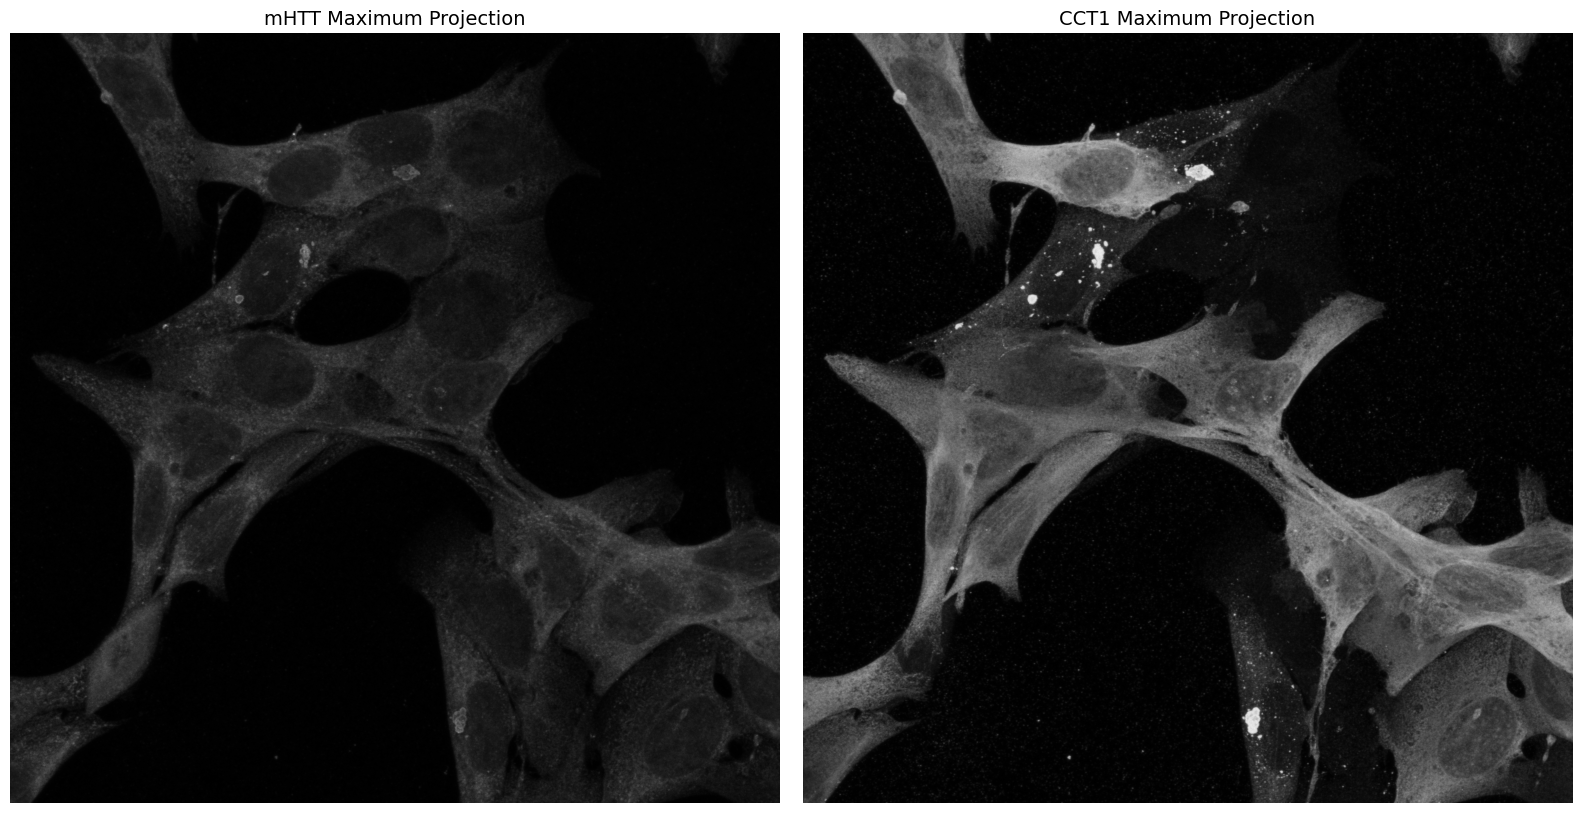

In [3]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects
from scipy.stats import pearsonr, mannwhitneyu
import tifffile

# Extract and prepare image data for mHTT
# Load mHTT data (returns a 3D stack with shape [Z, Y, X])
mhtt_data = tifffile.imread(mhtt_path)
cct1_data = tifffile.imread(cct1_path)

# Get number of z-slices
num_z_slices = mhtt_data.shape[0]

# Create a maximum intensity projection for initial display
mhtt_proj = np.max(mhtt_data, axis=0)
cct1_proj = np.max(cct1_data, axis=0)

# Normalize to 0-1 range for better visualization
mhtt_norm = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)
cct1_norm = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)

# Display the mHTT and CCT1 images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mhtt_norm, cmap='gray')
axs[0].set_title("mHTT Maximum Projection", fontsize=14)
axs[0].axis('off')

axs[1].imshow(cct1_norm, cmap='gray')
axs[1].set_title("CCT1 Maximum Projection", fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()

# Add interactive controls using ipywidgets

def update_visualization(z_slice=0, mhtt_strictness=4.0, cct1_strictness=4.0, 
                         sigma=1.0, min_size=20, mhtt_color='green', 
                         cct1_color='red', show_overlap_only=False, use_mip=True):
    """Update visualization based on slider values"""
    
    # Choose between MIP and z-slice
    if use_mip:
        # Use maximum intensity projection
        mhtt_slice = mhtt_proj
        cct1_slice = cct1_proj
        slice_title = "Maximum Projection"
    else:
        # Use selected z-slice
        mhtt_slice = mhtt_data[z_slice]
        cct1_slice = cct1_data[z_slice]
        slice_title = f"Z-Slice {z_slice}"
    
    # Normalize slices
    mhtt_norm_slice = (mhtt_slice - np.min(mhtt_slice)) / np.ptp(mhtt_slice)
    cct1_norm_slice = (cct1_slice - np.min(cct1_slice)) / np.ptp(cct1_slice)
    
    # Apply Gaussian blur with adjustable sigma
    mhtt_smooth = gaussian(mhtt_norm_slice, sigma=sigma)
    cct1_smooth = gaussian(cct1_norm_slice, sigma=sigma)
    
    # Get Otsu thresholds
    mhtt_otsu = threshold_otsu(mhtt_smooth)
    cct1_otsu = threshold_otsu(cct1_smooth)
    
    # Apply strictness factor from sliders
    mhtt_threshold = min(1.0, mhtt_otsu * mhtt_strictness)
    cct1_threshold = min(1.0, cct1_otsu * cct1_strictness)
    
    # Create binary masks
    mhtt_mask = mhtt_smooth > mhtt_threshold
    cct1_mask = cct1_smooth > cct1_threshold
    
    # Clean up small noise artifacts
    mhtt_mask = remove_small_objects(mhtt_mask, min_size=min_size)
    cct1_mask = remove_small_objects(cct1_mask, min_size=min_size)
    
    # Create an overlap mask where both are active
    overlap_mask = mhtt_mask & cct1_mask
    
    # Prepare color mapping - using RGB channels directly for better control
    composite = np.zeros((mhtt_norm_slice.shape[0], mhtt_norm_slice.shape[1], 3))
    
    # Configure colors based on selections
    color_map = {'red': 0, 'green': 1, 'blue': 2, 'magenta': [0,2], 'yellow': [0,1], 'cyan': [1,2]}
    
    if not show_overlap_only:
        # Add mHTT channel
        if mhtt_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm_slice * mhtt_mask
        else:  # Handle combined colors
            for channel in color_map[mhtt_color]:
                composite[:,:,channel] = mhtt_norm_slice * mhtt_mask
        
        # Add CCT1 channel
        if cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[cct1_color]] = cct1_norm_slice * cct1_mask
        else:  # Handle combined colors
            for channel in color_map[cct1_color]:
                composite[:,:,channel] = cct1_norm_slice * cct1_mask
    else:
        # Only show overlap
        if mhtt_color in ['red', 'green', 'blue'] and cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm_slice * overlap_mask
            composite[:,:,color_map[cct1_color]] = cct1_norm_slice * overlap_mask
    
    # Display the results
    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    
    # Create informative title
    title = f"{slice_title} - Thresholds: mHTT>{mhtt_threshold:.2f}, CCT1>{cct1_threshold:.2f}"
    if show_overlap_only:
        title += " (Overlap Only)"
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Display metrics
    mhtt_area = np.sum(mhtt_mask)
    cct1_area = np.sum(cct1_mask)
    overlap_area = np.sum(overlap_mask)
    
    print(f"mHTT area: {mhtt_area} pixels")
    print(f"CCT1 area: {cct1_area} pixels")
    print(f"Overlap area: {overlap_area} pixels")
    print(f"Overlap percentage: {100*overlap_area/mhtt_area:.2f}% of mHTT, {100*overlap_area/cct1_area:.2f}% of CCT1")
    
    return mhtt_mask, cct1_mask, overlap_mask, mhtt_threshold, cct1_threshold

# Function 4 colocalization analysis
def run_colocalization_analysis(b):
    
    # Create directory for reports if it doesn't exist
    report_dir = "colocalization_reports"
    if not os.path.exists(report_dir):
        os.makedirs(report_dir)
    
    # Generate timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = os.path.join(report_dir, f"colocalization_report_{timestamp}.pdf")
    
    # Get current parameter values
    z_slice = z_slice_slider.value
    mhtt_strictness = mhtt_strictness_slider.value
    cct1_strictness = cct1_strictness_slider.value
    sigma = sigma_slider.value
    min_size = min_size_slider.value
    use_mip = use_mip_toggle.value
    
    # Generate masks using current parameters
    mhtt_mask, cct1_mask, overlap_mask, mhtt_threshold, cct1_threshold = update_visualization(
        z_slice, mhtt_strictness, cct1_strictness, sigma, min_size, 
        mhtt_color.value, cct1_color.value, overlap_toggle.value, use_mip
    )
    
    # Select appropriate data based on mode
    if use_mip:
        mhtt_slice = mhtt_proj
        cct1_slice = cct1_proj
        slice_title = "Maximum Projection"
    else:
        mhtt_slice = mhtt_data[z_slice]
        cct1_slice = cct1_data[z_slice]
        slice_title = f"Z-Slice {z_slice}"
        
    # Normalize for analysis
    mhtt_norm_slice = (mhtt_slice - np.min(mhtt_slice)) / np.ptp(mhtt_slice)
    cct1_norm_slice = (cct1_slice - np.min(cct1_slice)) / np.ptp(cct1_slice)
    
    # Create union mask
    union_mask = mhtt_mask | cct1_mask
    
    # 1. Pearson's Correlation Coefficient
    # Get intensity values within the masks
    mhtt_values = mhtt_norm_slice[union_mask]
    cct1_values = cct1_norm_slice[union_mask]
    pearson_corr, pearson_p = pearsonr(mhtt_values, cct1_values)
    
    # 2. Manders' Coefficients
    # M1: fraction of mHTT overlapping with CCT1
    m1 = np.sum(mhtt_norm_slice * overlap_mask) / np.sum(mhtt_norm_slice * mhtt_mask) if np.sum(mhtt_norm_slice * mhtt_mask) > 0 else 0
    # M2: fraction of CCT1 overlapping with mHTT
    m2 = np.sum(cct1_norm_slice * overlap_mask) / np.sum(cct1_norm_slice * cct1_mask) if np.sum(cct1_norm_slice * cct1_mask) > 0 else 0
    
    # 3. Dice similarity coefficient
    dice = 2 * np.sum(overlap_mask) / (np.sum(mhtt_mask) + np.sum(cct1_mask)) if (np.sum(mhtt_mask) + np.sum(cct1_mask)) > 0 else 0
    
    # 4. Mann-Whitney U Test
    # Compare intensity distributions within the two masks
    mhtt_inside = mhtt_norm_slice[mhtt_mask & ~cct1_mask].flatten()
    mhtt_overlap = mhtt_norm_slice[overlap_mask].flatten()
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        u_stat, p_value = mannwhitneyu(mhtt_inside, mhtt_overlap, alternative='two-sided')
    else:
        u_stat, p_value = 0, 1
    
    # 5. Cohen's d (effect size)
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        mean_in = np.mean(mhtt_overlap)
        mean_out = np.mean(mhtt_inside)
        std_in = np.std(mhtt_overlap)
        std_out = np.std(mhtt_inside)
        pooled_std = np.sqrt(((len(mhtt_overlap) - 1) * std_in**2 + (len(mhtt_inside) - 1) * std_out**2) / 
                             (len(mhtt_overlap) + len(mhtt_inside) - 2))
        cohen_d = abs(mean_in - mean_out) / pooled_std if pooled_std > 0 else 0
    else:
        mean_in, mean_out, cohen_d = 0, 0, 0
    
    # 6. Intersection over Union (IoU)
    iou = np.sum(overlap_mask) / np.sum(union_mask) if np.sum(union_mask) > 0 else 0
    
    # Display results
    print(f"\n===== COLOCALIZATION ANALYSIS RESULTS ({slice_title}) =====")
    print(f"Parameters: mHTT factor={mhtt_strictness}, CCT1 factor={cct1_strictness}, sigma={sigma}, min_size={min_size}")
    print(f"Thresholds: mHTT>{mhtt_threshold:.4f}, CCT1>{cct1_threshold:.4f}")
    
    print("\n1. Pearson's Correlation Coefficient:")
    print(f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})")
    
    print("\n2. Manders' Coefficients:")
    print(f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}")
    print(f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}")
    
    print("\n3. Dice Similarity Coefficient:")
    print(f"   Dice = {dice:.4f}")
    
    print("\n4. Mann-Whitney U Test:")
    print(f"   U = {u_stat:.2f}")
    print(f"   p-value = {p_value:.8e}")
    
    print("\n5. Cohen's d (Effect Size):")
    print(f"   d = {cohen_d:.4f}")
    print(f"   Mean intensity in overlap: {mean_in:.2f}")
    print(f"   Mean intensity outside overlap: {mean_out:.2f}")
    
    print("\n6. Intersection over Union (IoU):")
    print(f"   IoU = {iou:.4f}")
    
    # Create figures for PDF export
    # Visualization of results
    fig_results, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show mHTT with mask outline
    axs[0].imshow(mhtt_norm_slice, cmap='gray')
    axs[0].contour(mhtt_mask, colors='green', linewidths=0.5)
    axs[0].set_title(f"mHTT {slice_title} with Threshold Contour", fontsize=14)
    axs[0].axis('off')
    
    # Show CCT1 with mask outline
    axs[1].imshow(cct1_norm_slice, cmap='gray')
    axs[1].contour(cct1_mask, colors='red', linewidths=0.5)
    axs[1].set_title(f"CCT1 {slice_title} with Threshold Contour", fontsize=14)
    axs[1].axis('off')
    
    # Show overlap visualization
    overlap_img = np.zeros((mhtt_norm_slice.shape[0], mhtt_norm_slice.shape[1], 3))
    overlap_img[:,:,1] = mhtt_norm_slice * mhtt_mask  # Green channel for mHTT
    overlap_img[:,:,0] = cct1_norm_slice * cct1_mask  # Red channel for CCT1
    overlap_img = np.clip(overlap_img, 0, 1)
    
    axs[2].imshow(overlap_img)
    axs[2].set_title("Colocalization Map", fontsize=14)
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create PDF report
    with PdfPages(pdf_filename) as pdf:
        # Title page
        fig_title = plt.figure(figsize=(8.5, 11))
        fig_title.suptitle("Colocalization Analysis Report", fontsize=16, y=0.95)
        plt.figtext(0.5, 0.85, f"Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                   ha='center', fontsize=12)
        plt.figtext(0.5, 0.80, f"mHTT Path: {os.path.basename(mhtt_path)}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.77, f"CCT1 Path: {os.path.basename(cct1_path)}", ha='center', fontsize=10)
        
        # Analysis mode
        plt.figtext(0.5, 0.72, f"Analysis Mode: {slice_title}", ha='center', fontsize=12, weight='bold')
        
        plt.figtext(0.5, 0.67, "Analysis Parameters:", ha='center', fontsize=12, weight='bold')
        plt.figtext(0.5, 0.63, f"mHTT threshold factor: {mhtt_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.60, f"CCT1 threshold factor: {cct1_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.57, f"Gaussian sigma: {sigma}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.54, f"Min object size: {min_size} pixels", ha='center', fontsize=10)
        plt.figtext(0.5, 0.51, f"mHTT color: {mhtt_color.value}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.48, f"CCT1 color: {cct1_color.value}", ha='center', fontsize=10)
        plt.axis('off')
        pdf.savefig(fig_title)
        plt.close(fig_title)
        
        # Results summary page
        fig_summary = plt.figure(figsize=(8.5, 11))
        fig_summary.suptitle("Colocalization Metrics Summary", fontsize=16, y=0.95)
        
        # Basic metrics
        plt.figtext(0.1, 0.90, "Basic Metrics:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.87, f"mHTT area: {np.sum(mhtt_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.84, f"CCT1 area: {np.sum(cct1_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.81, f"Overlap area: {np.sum(overlap_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.78, f"Overlap percentage: {100*np.sum(overlap_mask)/np.sum(mhtt_mask):.2f}% of mHTT, {100*np.sum(overlap_mask)/np.sum(cct1_mask):.2f}% of CCT1", fontsize=10)
        
        # Detailed metrics
        plt.figtext(0.1, 0.73, "1. Pearson's Correlation Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.70, f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})", fontsize=10)
        
        plt.figtext(0.1, 0.65, "2. Manders' Coefficients:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.62, f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}", fontsize=10)
        plt.figtext(0.1, 0.59, f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.54, "3. Dice Similarity Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.51, f"   Dice = {dice:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.46, "4. Mann-Whitney U Test:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.43, f"   U = {u_stat:.2f}", fontsize=10)
        plt.figtext(0.1, 0.40, f"   p-value = {p_value:.8e}", fontsize=10)
        
        plt.figtext(0.1, 0.35, "5. Cohen's d (Effect Size):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.32, f"   d = {cohen_d:.4f}", fontsize=10)
        plt.figtext(0.1, 0.29, f"   Mean intensity in overlap: {mean_in:.2f}", fontsize=10)
        plt.figtext(0.1, 0.26, f"   Mean intensity outside overlap: {mean_out:.2f}", fontsize=10)
        
        plt.figtext(0.1, 0.21, "6. Intersection over Union (IoU):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.18, f"   IoU = {iou:.4f}", fontsize=10)
        
        plt.figtext(0.5, 0.05, f"Report saved to: {pdf_filename}", ha='center', fontsize=8, style='italic')
        plt.axis('off')
        pdf.savefig(fig_summary)
        plt.close(fig_summary)
        
        # Add visualization page
        pdf.savefig(fig_results)
        plt.close(fig_results)
        
    print(f"\nPDF report generated and saved to: {pdf_filename}")

# Create sliders
z_slice_slider = widgets.IntSlider(
    value=0, min=0, max=num_z_slices-1, step=1,
    description='Z-Slice:',
    style={'description_width': 'initial'}
)

mhtt_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='mHTT Factor:',
    style={'description_width': 'initial'}
)

cct1_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='CCT1 Factor:',
    style={'description_width': 'initial'}
)

sigma_slider = widgets.FloatSlider(
    value=1.0, min=0.1, max=5.0, step=0.1,
    description='Gaussian σ:',
    style={'description_width': 'initial'}
)

min_size_slider = widgets.IntSlider(
    value=20, min=1, max=100, step=5,
    description='Min Size:',
    style={'description_width': 'initial'}
)

mhtt_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='green',
    description='mHTT Color:',
    style={'description_width': 'initial'}
)

cct1_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='red',
    description='CCT1 Color:',
    style={'description_width': 'initial'}
)

overlap_toggle = widgets.Checkbox(
    value=False,
    description='Show overlap only',
    style={'description_width': 'initial'}
)

use_mip_toggle = widgets.Checkbox(
    value=True,
    description='Use maximum intensity projection',
    style={'description_width': 'initial'}
)

# Add button for colocalization analysis
colocalize_button = widgets.Button(
    description='Run Colocalization Analysis',
    button_style='success',
    tooltip='Calculate advanced colocalization metrics with current parameters'
)

# Connect the button to the function
colocalize_button.on_click(run_colocalization_analysis)

# Create interactive widget
interactive_plot = widgets.interactive(
    update_visualization,
    z_slice=z_slice_slider,
    mhtt_strictness=mhtt_strictness_slider,
    cct1_strictness=cct1_strictness_slider,
    sigma=sigma_slider,
    min_size=min_size_slider,
    mhtt_color=mhtt_color,
    cct1_color=cct1_color,
    show_overlap_only=overlap_toggle,
    use_mip=use_mip_toggle
)

# Display the widget and the button
display(widgets.VBox([interactive_plot, colocalize_button]))


In [4]:
#here i calculate the enrichment metrics over a Maximum Intensity Projection (instead of full 3D)
# Get current parameters from sliders
z_slice_val = z_slice_slider.value
mhtt_strictness_val = mhtt_strictness_slider.value
cct1_strictness_val = cct1_strictness_slider.value
sigma_val = sigma_slider.value
min_size_val = min_size_slider.value
use_mip_val = use_mip_toggle.value

# 1. Global Pearson's Correlation Coefficient (PCC) on full 3D data
# Ensure data is not empty and has variation
if mhtt_data.size > 0 and cct1_data.size > 0 and np.ptp(mhtt_data) > 0 and np.ptp(cct1_data) > 0:
    pcc_global, p_value_global = pearsonr(mhtt_data.flatten(), cct1_data.flatten())
else:
    pcc_global, p_value_global = np.nan, np.nan
print(f"Global Pearson's r (PCC) on 3D data: {pcc_global:.3f} (p-value: {p_value_global:.3e})")

# 2. Prepare image data and masks based on current widget parameters
if use_mip_val:
    mhtt_current_img = mhtt_proj
    cct1_current_img = cct1_proj
    current_view_desc = "Maximum Intensity Projection"
else:
    mhtt_current_img = mhtt_data[z_slice_val]
    cct1_current_img = cct1_data[z_slice_val]
    current_view_desc = f"Z-Slice {z_slice_val}"
print(f"\nCalculating metrics for: {current_view_desc}")

# Normalize current images (avoid division by zero if an image is flat)
mhtt_ptp = np.ptp(mhtt_current_img)
cct1_ptp = np.ptp(cct1_current_img)

mhtt_norm_current_img = (mhtt_current_img - np.min(mhtt_current_img)) / mhtt_ptp if mhtt_ptp > 0 else np.zeros_like(mhtt_current_img)
cct1_norm_current_img = (cct1_current_img - np.min(cct1_current_img)) / cct1_ptp if cct1_ptp > 0 else np.zeros_like(cct1_current_img)

# Apply Gaussian blur
mhtt_smooth = gaussian(mhtt_norm_current_img, sigma=sigma_val)
cct1_smooth = gaussian(cct1_norm_current_img, sigma=sigma_val)

# Get Otsu thresholds (handle cases where smooth image is flat)
mhtt_otsu = threshold_otsu(mhtt_smooth) if np.ptp(mhtt_smooth) > 0 else 0
cct1_otsu = threshold_otsu(cct1_smooth) if np.ptp(cct1_smooth) > 0 else 0

# Apply strictness factor
mhtt_threshold_val = min(1.0, mhtt_otsu * mhtt_strictness_val)
cct1_threshold_val = min(1.0, cct1_otsu * cct1_strictness_val)

# Create binary masks
mhtt_mask_current = mhtt_smooth > mhtt_threshold_val
cct1_mask_current = cct1_smooth > cct1_threshold_val

# Clean up small noise artifacts
mhtt_mask_current = remove_small_objects(mhtt_mask_current, min_size=min_size_val)
cct1_mask_current = remove_small_objects(cct1_mask_current, min_size=min_size_val)

# 3. Dice Similarity Coefficient (on current view)
intersection_current = np.logical_and(mhtt_mask_current, cct1_mask_current)
mhtt_sum = mhtt_mask_current.sum()
cct1_sum = cct1_mask_current.sum()
denominator_dice = mhtt_sum + cct1_sum
dice_current = (2. * intersection_current.sum() / denominator_dice) if denominator_dice > 0 else 0.0
print(f"Dice Similarity Coefficient: {dice_current:.3f}")

# 4. Intersection over Union (IoU) (on current view)
union_current = np.logical_or(mhtt_mask_current, cct1_mask_current)
union_sum = union_current.sum()
iou_current = (intersection_current.sum() / union_sum) if union_sum > 0 else 0.0
print(f"Intersection over Union (IoU): {iou_current:.3f}")

# 5. Manders' Coefficients (user's version, on current view's raw intensities)
# M1: fraction of CCT1 intensity within mHTT mask / total CCT1 intensity in current view
sum_cct1_current_img = np.sum(cct1_current_img)
manders_m1_user = (np.sum(cct1_current_img[mhtt_mask_current]) / sum_cct1_current_img) if sum_cct1_current_img > 0 and mhtt_sum > 0 else 0.0

# M2: fraction of mHTT intensity within CCT1 mask / total mHTT intensity in current view
sum_mhtt_current_img = np.sum(mhtt_current_img)
manders_m2_user = (np.sum(mhtt_current_img[cct1_mask_current]) / sum_mhtt_current_img) if sum_mhtt_current_img > 0 and cct1_sum > 0 else 0.0
print(f"Manders' Coefficients (user version): M1 (CCT1 in mHTT) = {manders_m1_user:.3f}, M2 (mHTT in CCT1) = {manders_m2_user:.3f}")

# 6. Enrichment Stats (CCT1 intensity inside vs. outside mHTT mask, on current view's normalized intensities)
# Using normalized intensities for these stats, can be switched to cct1_current_img if raw values are preferred
if mhtt_sum > 0 and mhtt_mask_current.size > mhtt_sum : # Ensure both inside and outside regions can exist
    inside_cct1_intensity = cct1_norm_current_img[mhtt_mask_current]
    outside_cct1_intensity = cct1_norm_current_img[np.logical_not(mhtt_mask_current)]

    if inside_cct1_intensity.size > 0 and outside_cct1_intensity.size > 0:
        u_stat, p_value_mw = mannwhitneyu(inside_cct1_intensity, outside_cct1_intensity, alternative='two-sided')

        mean_in = np.mean(inside_cct1_intensity)
        mean_out = np.mean(outside_cct1_intensity)
        std_in = np.std(inside_cct1_intensity, ddof=1)
        std_out = np.std(outside_cct1_intensity, ddof=1)
        n_in = len(inside_cct1_intensity)
        n_out = len(outside_cct1_intensity)

        # Pooled standard deviation for Cohen's d
        if (n_in + n_out - 2) > 0 :
             pooled_std = np.sqrt(((n_in - 1) * std_in**2 + (n_out - 1) * std_out**2) / (n_in + n_out - 2))
             cohen_d = (mean_in - mean_out) / pooled_std if pooled_std > 0 else 0.0
        else: # Handles cases with very few data points (n_in=1, n_out=1)
            pooled_std = 0.0
            cohen_d = 0.0


        fold_change = mean_in / mean_out if mean_out > 0 else np.inf

        print(f"Mann–Whitney U test (CCT1 intensity in mHTT mask vs. out): U = {u_stat:.3f}, p = {p_value_mw:.3e}")
        print(f"Cohen's d: {cohen_d:.3f}")
        print(f"Fold Change (mean CCT1 intensity in mHTT mask / out of mHTT mask): {fold_change:.3f}")
    else:
        print("Not enough data for Mann-Whitney U test, Cohen's d, or Fold Change (e.g., mask covers everything or nothing).")
else:
    print("mHTT mask is empty or covers the entire image. Cannot compute enrichment statistics.")


Global Pearson's r (PCC) on 3D data: 0.845 (p-value: 0.000e+00)

Calculating metrics for: Maximum Intensity Projection
Dice Similarity Coefficient: 0.403
Intersection over Union (IoU): 0.252
Manders' Coefficients (user version): M1 (CCT1 in mHTT) = 0.012, M2 (mHTT in CCT1) = 0.007
Mann–Whitney U test (CCT1 intensity in mHTT mask vs. out): U = 37777610279.500, p = 0.000e+00
Cohen's d: 3.401
Fold Change (mean CCT1 intensity in mHTT mask / out of mHTT mask): 5.516


In [5]:
# 1. Global Pearson's Correlation Coefficient (PCC) on full 3D data
if mhtt_data.size > 0 and cct1_data.size > 0 and np.ptp(mhtt_data) > 0 and np.ptp(cct1_data) > 0:
    pcc_global, p_value_global = pearsonr(mhtt_data.flatten(), cct1_data.flatten())
else:
    pcc_global, p_value_global = np.nan, np.nan
print(f"Global Pearson's r (PCC) on 3D data: {pcc_global:.3f} (p-value: {p_value_global:.3e})")

# 2. Now loop over all z-slices
dice_vals = []
iou_vals = []
manders_m1_vals = []
manders_m2_vals = []
mw_p_vals = []
mw_u_vals = []  # New list to store U statistics
cohen_d_vals = []
fold_change_vals = []

for z_val in range(mhtt_data.shape[0]):
    # Get current slice images
    mhtt_current_img = mhtt_data[z_val]
    cct1_current_img = cct1_data[z_val]
    
    # Normalize current images (avoid division by 0 if flat)
    mhtt_ptp = np.ptp(mhtt_current_img)
    cct1_ptp = np.ptp(cct1_current_img)
    mhtt_norm = (mhtt_current_img - np.min(mhtt_current_img)) / mhtt_ptp if mhtt_ptp > 0 else np.zeros_like(mhtt_current_img)
    cct1_norm = (cct1_current_img - np.min(cct1_current_img)) / cct1_ptp if cct1_ptp > 0 else np.zeros_like(cct1_current_img)
    
    # Apply Gaussian blur
    mhtt_smooth = gaussian(mhtt_norm, sigma=sigma_val)
    cct1_smooth = gaussian(cct1_norm, sigma=sigma_val)
    
    # Get Otsu thresholds (if valid)
    mhtt_otsu = threshold_otsu(mhtt_smooth) if np.ptp(mhtt_smooth) > 0 else 0
    cct1_otsu = threshold_otsu(cct1_smooth) if np.ptp(cct1_smooth) > 0 else 0
    
    # Apply strictness factor
    mhtt_threshold_val = min(1.0, mhtt_otsu * mhtt_strictness_val)
    cct1_threshold_val = min(1.0, cct1_otsu * cct1_strictness_val)
    
    # Create binary masks
    mhtt_mask = mhtt_smooth > mhtt_threshold_val
    cct1_mask = cct1_smooth > cct1_threshold_val

    # Remove small objects from the masks
    mhtt_mask = remove_small_objects(mhtt_mask, min_size=min_size_val)
    cct1_mask = remove_small_objects(cct1_mask, min_size=min_size_val)
    
    # 3. Dice Similarity Coefficient
    intersection = np.logical_and(mhtt_mask, cct1_mask)
    mhtt_sum = mhtt_mask.sum()
    cct1_sum = cct1_mask.sum()
    dice = (2.0 * intersection.sum() / (mhtt_sum + cct1_sum)) if (mhtt_sum + cct1_sum) > 0 else 0.0
    dice_vals.append(dice)
    
    # 4. Intersection over Union (IoU)
    union = np.logical_or(mhtt_mask, cct1_mask)
    iou = (intersection.sum() / union.sum()) if union.sum() > 0 else 0.0
    iou_vals.append(iou)
    
    # 5. Manders' Coefficients (user's version)
    sum_cct1 = cct1_current_img.sum()
    m1 = (cct1_current_img[mhtt_mask].sum() / sum_cct1) if sum_cct1 > 0 and mhtt_sum > 0 else 0.0
    sum_mhtt = mhtt_current_img.sum()
    m2 = (mhtt_current_img[cct1_mask].sum() / sum_mhtt) if sum_mhtt > 0 and cct1_sum > 0 else 0.0
    manders_m1_vals.append(m1)
    manders_m2_vals.append(m2)
    
    # 6. Enrichment Stats (Mann–Whitney U test, Cohen's d, and Fold Change)
    if mhtt_sum > 0 and mhtt_mask.size > mhtt_sum:
        inside = cct1_norm[mhtt_mask]
        outside = cct1_norm[np.logical_not(mhtt_mask)]
        if inside.size > 0 and outside.size > 0:
            u_stat, p_val = mannwhitneyu(inside, outside, alternative='two-sided')
            mw_p_vals.append(p_val)
            mw_u_vals.append(u_stat)  # Store the U statistic
            mean_in = np.mean(inside)
            mean_out = np.mean(outside)
            std_in = np.std(inside, ddof=1)
            std_out = np.std(outside, ddof=1)
            n_in = len(inside)
            n_out = len(outside)
            if (n_in + n_out - 2) > 0:
                pooled_std = np.sqrt(((n_in - 1)*std_in**2 + (n_out - 1)*std_out**2) / (n_in + n_out - 2))
                d = (mean_in - mean_out) / pooled_std if pooled_std > 0 else 0.0
            else:
                d = 0.0
            cohen_d_vals.append(d)
            fold = mean_in / mean_out if mean_out > 0 else np.inf
            fold_change_vals.append(fold)
        else:
            mw_p_vals.append(np.nan)
            mw_u_vals.append(np.nan)  # Add NaN for missing U statistic
            cohen_d_vals.append(np.nan)
            fold_change_vals.append(np.nan)
    else:
        mw_p_vals.append(np.nan)
        mw_u_vals.append(np.nan)  # Add NaN for missing U statistic
        cohen_d_vals.append(np.nan)
        fold_change_vals.append(np.nan)

# Compute mean values (ignoring any NaNs)
mean_dice = np.nanmean(dice_vals)
mean_iou = np.nanmean(iou_vals)
mean_manders_m1 = np.nanmean(manders_m1_vals)
mean_manders_m2 = np.nanmean(manders_m2_vals)
mean_mw_p = np.nanmean(mw_p_vals)
mean_mw_u = np.nanmean(mw_u_vals)  # Calculate mean U statistic
mean_cohen_d = np.nanmean(cohen_d_vals)
mean_fold_change = np.nanmean(fold_change_vals)

print("\nAverage metrics over all z-slices:")
print(f"Dice Similarity Coefficient: {mean_dice:.3f}")
print(f"Intersection over Union (IoU): {mean_iou:.3f}")
print(f"Manders' Coefficients (user version): M1 = {mean_manders_m1:.3f}, M2 = {mean_manders_m2:.3f}")
print(f"Mann–Whitney U test p-value (mean): {mean_mw_p:.3e} (small value means a statistically significant difference in CCT1 intensity distributions between 'inside' and 'outside' mHTT mask regions, on average across z-slices)")
print(f"Mann–Whitney U test U-value (mean): {mean_mw_u:.3e}")
print(f"Cohen's d (mean): {mean_cohen_d:.3f}")
print(f"Fold Change (mean): {mean_fold_change:.3f}")


Global Pearson's r (PCC) on 3D data: 0.845 (p-value: 0.000e+00)

Average metrics over all z-slices:
Dice Similarity Coefficient: 0.248
Intersection over Union (IoU): 0.145
Manders' Coefficients (user version): M1 = 0.018, M2 = 0.010
Mann–Whitney U test p-value (mean): 0.000e+00 (small value means a statistically significant difference in CCT1 intensity distributions between 'inside' and 'outside' mHTT mask regions, on average across z-slices)
Mann–Whitney U test U-value (mean): 3.639e+10
Cohen's d (mean): 4.776
Fold Change (mean): 10.847


Interpretation: CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)


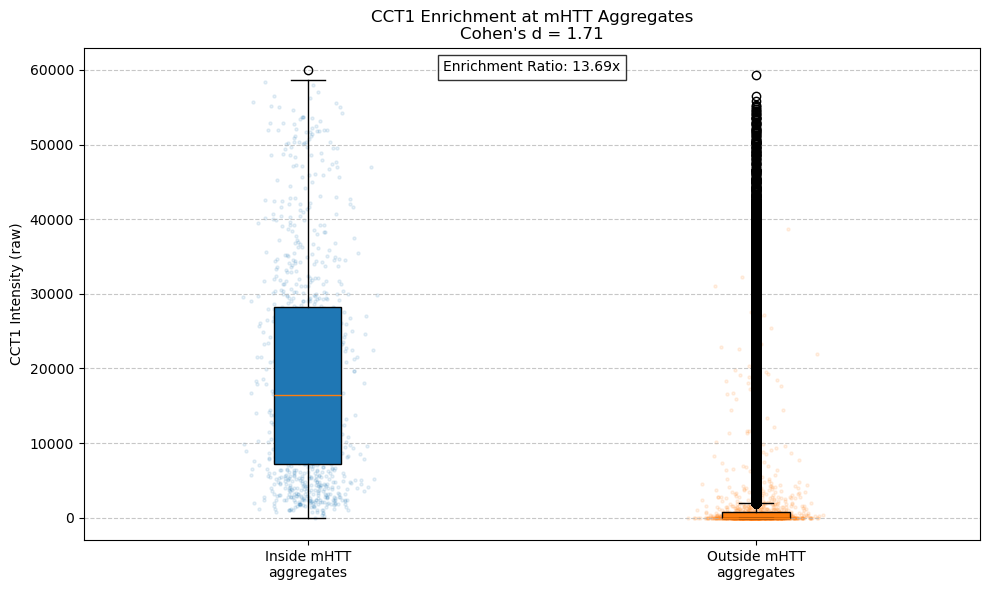

In [6]:
# enrichment boxplot
if 'cct1_current_img' in locals() and 'mhtt_mask_current' in locals():
    cct1_inside = cct1_current_img[mhtt_mask_current]  # Inside mHTT aggregates
    cct1_outside = cct1_current_img[np.logical_not(mhtt_mask_current)]  # Outside mHTT aggregates

    # Calculate summary statistics
    mean_inside = np.mean(cct1_inside) if cct1_inside.size > 0 else np.nan
    mean_outside = np.mean(cct1_outside) if cct1_outside.size > 0 else np.nan
    median_inside = np.median(cct1_inside) if cct1_inside.size > 0 else np.nan
    median_outside = np.median(cct1_outside) if cct1_outside.size > 0 else np.nan
    
    if mean_outside > 0 and not np.isnan(mean_inside):
        enrichment_ratio = mean_inside / mean_outside
    elif not np.isnan(mean_inside) and mean_outside == 0 : # Handle case where outside is zero but inside is not
        enrichment_ratio = float('inf')
    else: # Handle cases where mean_inside is nan or both are zero/nan
        enrichment_ratio = float('nan')


    # Perform Mann-Whitney U test to assess if CCT1 is significantly enriched at mHTT sites
    # Using alternative='greater' to test if values inside are significantly greater than outside
    if cct1_inside.size > 0 and cct1_outside.size > 0:
        u_stat, p_value = mannwhitneyu(cct1_inside, cct1_outside, alternative='greater')
    else:
        u_stat, p_value = np.nan, np.nan

    # Calculate Cohen's d for effect size
    # Cohen's d = (Mean1 - Mean2) / sqrt((SD1^2 + SD2^2) / 2)
    def cohens_d(data1, data2):
        n1, n2 = len(data1), len(data2)
        if n1 == 0 or n2 == 0:
            return float('nan')
        
        mean1, mean2 = np.mean(data1), np.mean(data2)
        var1 = np.var(data1, ddof=1) # Sample variance
        var2 = np.var(data2, ddof=1) # Sample variance
        
        if np.isnan(var1) or np.isnan(var2): # Handles cases where variance cannot be computed (e.g. single data point)
             return float('nan')

        # Using the formula from the snippet: unweighted average of variances for pooled_std
        pooled_std = np.sqrt((var1 + var2) / 2) 
        
        if pooled_std > 0:
            return (mean1 - mean2) / pooled_std
        elif mean1 == mean2: # If means are same and std is zero, d is 0
            return 0.0
        else: # If means differ but std is zero (e.g. all points identical within groups but different between groups)
            return float('inf') if (mean1 - mean2) > 0 else float('-inf')


    effect_size = cohens_d(cct1_inside, cct1_outside)

    # # Print results
    # print(f"\n--- CCT1 Enrichment Analysis (using raw intensities from current view) ---")
    # print(f"CCT1 inside mHTT aggregates: mean = {mean_inside:.2f}, median = {median_inside:.2f} (n={cct1_inside.size})")
    # print(f"CCT1 outside mHTT aggregates: mean = {mean_outside:.2f}, median = {median_outside:.2f} (n={cct1_outside.size})")
    # print(f"Enrichment ratio (mean inside/outside): {enrichment_ratio:.2f}x")
    # print(f"Mann-Whitney U test (inside > outside): U = {u_stat}, p-value = {p_value:.6e}")
    # print(f"Effect size (Cohen's d): {effect_size:.2f}")

    # Interpret the results
    interpretation = "Interpretation unavailable (statistics could not be computed)."
    if not np.isnan(p_value) and not np.isnan(effect_size):
        if p_value < 0.05:
            if effect_size > 0.8:
                interpretation = "CCT1 is STRONGLY enriched at mHTT aggregate sites (large effect)"
            elif effect_size > 0.5:
                interpretation = "CCT1 is MODERATELY enriched at mHTT aggregate sites (medium effect)"
            elif effect_size > 0.2:
                interpretation = "CCT1 is WEAKLY enriched at mHTT aggregate sites (small effect)"
            else: # p < 0.05 but effect_size <= 0.2
                interpretation = "CCT1 is statistically enriched but with negligible or small effect size"
        else: # p_value >= 0.05
            interpretation = "No significant enrichment of CCT1 at mHTT aggregate sites"

    print(f"Interpretation: {interpretation}")

    # Create visualization
    if cct1_inside.size > 0 or cct1_outside.size > 0: 
        plt.figure(figsize=(10, 6))

        box_positions = [1, 2]
        box_data_to_plot = []
        labels_to_plot = []
        colors_to_plot = []
        
        all_box_data = [cct1_inside, cct1_outside]
        all_labels = ['Inside mHTT\naggregates', 'Outside mHTT\naggregates']
        all_colors = ['#1f77b4', '#ff7f0e'] # Blue for inside, orange for outside

        for i, data in enumerate(all_box_data):
            if data.size > 0:
                box_data_to_plot.append(data)
                labels_to_plot.append(all_labels[i])
                colors_to_plot.append(all_colors[i])
        
        if box_data_to_plot: # If there's still data after filtering
            box = plt.boxplot(box_data_to_plot, positions=box_positions[:len(box_data_to_plot)], patch_artist=True, labels=labels_to_plot)

            # Color the boxes
            for patch, color in zip(box['boxes'], colors_to_plot):
                patch.set_facecolor(color)

            # Add individual datapoints with jitter (semi-transparent)
            for i, data in enumerate(box_data_to_plot):
                # If there are too many points, sample a subset
                if len(data) > 1000:
                    np.random.seed(42)  # For reproducibility
                    indices = np.random.choice(len(data), size=1000, replace=False)
                    data_sample = data[indices]
                else:
                    data_sample = data
                
                # Add jitter to x-position
                x_pos = box_positions[i]
                x_jitter = np.random.normal(x_pos, 0.05, size=len(data_sample))
                plt.scatter(x_jitter, data_sample, alpha=0.1, s=5, c=colors_to_plot[i])

        plt.ylabel('CCT1 Intensity (raw)')
        plt.title(f'CCT1 Enrichment at mHTT Aggregates\nCohen\'s d = {effect_size:.2f}') #to provide a quantitative measure of the effect size directly alongside the visual representation of the data.
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Text annotation for the enrichment ratio
        if not np.isnan(enrichment_ratio) and len(box_data_to_plot) == 2: # Only if both groups are present
             plt.text(1.5, plt.ylim()[1] * 0.95, f"Enrichment Ratio: {enrichment_ratio:.2f}x", 
                 horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
        elif not np.isnan(enrichment_ratio) and len(box_data_to_plot) == 1: # If only one group, place it differently
             plt.text(box_positions[0], plt.ylim()[1] * 0.95, f"Enrichment Ratio: {enrichment_ratio:.2f}x (relative to absent group)", 
                 horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.8))


        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to generate CCT1 enrichment plot (both inside and outside masks are empty).")
else:
    print("Error: 'cct1_current_img' or 'mhtt_mask_current' not found. Please run the previous cell to define them.")


In [7]:
nucleus_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/run_example_images/annotated/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=2.tif'
nucleus_data = tifffile.imread(nucleus_path)  # shape: (Z, Y, X)

# Continue as before...
image_array = np.stack([mhtt_data, cct1_data, nucleus_data], axis=1)
nucleus_channel_index = 2

nucleus_img = image_array[:, nucleus_channel_index, :, :].max(axis=0)
nucleus_otsu = threshold_otsu(nucleus_img)
nucleus_mask = nucleus_img > nucleus_otsu


In [8]:
# Simple Dice coefficient function
def compute_dice(mask1, mask2):
    intersection = (mask1 & mask2).sum()
    size1 = mask1.sum()
    size2 = mask2.sum()
    if size1 + size2 == 0:
        return 0.0  # avoid division by zero
    return 2.0 * intersection / (size1 + size2)

# Assuming you already have:
# - nucleus_mask (binary numpy array)
# - mhtt_mask (binary numpy array)
# - cct1_mask (binary numpy array, if you have one — or thresholded CCT1 signal)

# Example usage:
dice_nucleus_mhtt = compute_dice(nucleus_mask, mhtt_mask)
print(f"Dice(nucleus, mHTT): {dice_nucleus_mhtt:.4f}")

dice_nucleus_cct1 = compute_dice(nucleus_mask, cct1_mask)
print(f"Dice(nucleus, CCT1): {dice_nucleus_cct1:.4f}")

Dice(nucleus, mHTT): 0.0011
Dice(nucleus, CCT1): 0.0002
